In [92]:
from __future__ import unicode_literals, print_function, division
import os, glob, random
from io import open
import unicodedata, string
# thanks to https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [55]:
def find_files(path): 
    return glob.glob(path)
print(find_files('../dataset/data/names/*.txt'))

def unicode_to_ascii(s, all_letters):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters
    )

all_letters = string.ascii_letters + ".,;''"
n_letters = len(all_letters)
print(unicode_to_ascii('Ślusàrski', all_letters))

['../dataset/data/names/Czech.txt', '../dataset/data/names/German.txt', '../dataset/data/names/Arabic.txt', '../dataset/data/names/Japanese.txt', '../dataset/data/names/Chinese.txt', '../dataset/data/names/Vietnamese.txt', '../dataset/data/names/Russian.txt', '../dataset/data/names/French.txt', '../dataset/data/names/Irish.txt', '../dataset/data/names/English.txt', '../dataset/data/names/Spanish.txt', '../dataset/data/names/Greek.txt', '../dataset/data/names/Italian.txt', '../dataset/data/names/Portuguese.txt', '../dataset/data/names/Scottish.txt', '../dataset/data/names/Dutch.txt', '../dataset/data/names/Korean.txt', '../dataset/data/names/Polish.txt']
Slusarski


In [91]:
import collections


def read_lines(filename):
    f = open(filename, encoding='utf-8')
    content = f.read().strip().split('\n')  # good trick to make document into list, strip() remove leading and trailing space.  
    res = [unicode_to_ascii(name, all_letters) for name in content]
    return res

def categorize(path = '../dataset/data/names/*.txt'):
    category_lines = collections.defaultdict(list)
  
    pathes = find_files(path)
    for filename in pathes:
        basename = os.path.basename(filename)      # output Chinese.txt, this is removing leading directory. 
        category = os.path.splitext(basename)[0]   # this splits the filename and the extension. 
        all_categories.append(category)
        lines = read_lines(filename)
        category_lines[category] = lines
    return category_lines
all_categories = []
category_lines = categorize()
# print(category_lines)
n_categories = len(all_categories)
print(n_categories)                               
print(category_lines["Italian"][:5]) 
print(all_categories)

18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [63]:
import torch
def letter2idx(letter): return all_letters.find(letter)
def letter2tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter2idx(letter)] = 1
    return tensor
def line2tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)  # tensor treate everything with batch
    for i, char in enumerate(line):
        tensor[i][0][letter2idx(char)] = 1
    return tensor

print(letter2tensor('J'))
print(line2tensor("adfadf"))



tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

In [113]:
import torch.nn as nn
activations = nn.ModuleDict([
    ['lrelu', nn.LeakyReLU()],
    ['relu', nn.ReLU()],
    ['selu', nn.SELU(inplace=True)],
    ['tanh', nn.Tanh()],
    ['softmax', nn.LogSoftmax(dim=1)],
    ['none', nn.Identity()],
])

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
#         self.activation = nn.LogSoftmax(dim=1)
        self.activation = activations['softmax']
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) 
        output = self.i2o(combined)
        output = self.activation(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
# input = letter2tensor('A')
# hidden = torch.zeros(1, n_hidden)
# output, next_hidden = rnn(input, hidden)
# print(output, next_hidden)

input = line2tensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output, next_hidden)




tensor([[-2.8826, -2.8390, -2.9042, -2.9090, -2.9002, -2.8319, -2.8617, -2.7953,
         -2.8502, -2.8379, -2.7982, -3.0206, -3.0214, -3.0265, -2.8881, -2.9489,
         -2.8679, -2.8854]], grad_fn=<LogSoftmaxBackward>) tensor([[-0.0492, -0.0127,  0.0291,  0.0289,  0.1042,  0.0219,  0.1211,  0.0424,
          0.0195, -0.0312, -0.0945,  0.0056, -0.1048, -0.0493, -0.0254, -0.0278,
         -0.0576, -0.0088, -0.1218, -0.0969, -0.1006, -0.0708,  0.0962,  0.0983,
          0.0408, -0.0523,  0.0734, -0.1359, -0.0206, -0.0625,  0.0694,  0.0884,
         -0.0624,  0.0245,  0.0708, -0.1009, -0.0184, -0.0982,  0.0381, -0.0105,
         -0.0511, -0.0242,  0.0076,  0.0018,  0.0848, -0.0666, -0.0047,  0.0827,
          0.0488,  0.0160,  0.0251,  0.0339, -0.0125, -0.0153,  0.0198,  0.0196,
         -0.0942,  0.0031, -0.0424, -0.0062, -0.0238, -0.0172, -0.0138, -0.0294,
          0.0364,  0.1066,  0.0710, -0.0050,  0.0095, -0.1025, -0.0586,  0.0464,
          0.0632, -0.0735, -0.1033, -0.1052, -0.11

In [114]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print(category_from_output(output))

def random_choice(arr):
    return arr[random.randint(0, len(arr) - 1)]

def get_training_sample():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    line_tensor = line2tensor(line)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = get_training_sample()
    print('category =', category, '/ line = ', line )

('French', 7)
category = Russian / line =  Ponikarov
category = Dutch / line =  Krantz
category = Arabic / line =  Maalouf
category = French / line =  Duchamps
category = French / line =  Chevalier
category = German / line =  Lawrenz
category = French / line =  Lane
category = Portuguese / line =  Ramires
category = Korean / line =  Tsai
category = Russian / line =  Hamatnurov


In [111]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(line_tensor, category_tensor):
    hidden = rnn.initHidden()   # note: hidden layer needs to initilize each time trian with a word, get each letter and pass sequencly to with hidden layer. 
    rnn.train()
    rnn.zero_grad()  # note, need to zero_grad outside the for loop, one zero when finish one word
    
    for i in range(line_tensor.size()[0]):  # number of letters in this word
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

import time, math
n_iters = 100000
print_every = 500
plot_every = 100

def time_elapse(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' %(m, s)
current_loss = 0
all_losses = []
start = time.time()

for iter in range(1, n_iters + 1):
    
    category, line, category_tensor, line_tensor = get_training_sample()
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        pred, pred_idx = category_from_output(output)
        correct = '✓' if pred == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, 
                    time_elapse(start), loss, line, pred, correct))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    
    

500 0% (0m 1s) 0.2496 Jang / Korean ✓
1000 1% (0m 2s) 0.3504 Sook / Korean ✓
1500 1% (0m 4s) 0.9836 Pinho / Portuguese ✓
2000 2% (0m 5s) 0.3520 Gorka / Polish ✓
2500 2% (0m 6s) 2.2284 Cattaneo / Spanish ✗ (Italian)
3000 3% (0m 8s) 0.3525 Pezos / Greek ✓
3500 3% (0m 9s) 0.0322 O'Grady / Irish ✓
4000 4% (0m 10s) 0.7074 Kafka / Czech ✓
4500 4% (0m 11s) 3.6135 Woodham / Arabic ✗ (English)
5000 5% (0m 13s) 0.1103 Hiroyuki / Japanese ✓
5500 5% (0m 14s) 3.4560 Donn / Vietnamese ✗ (English)
6000 6% (0m 15s) 0.2504 Williamson / Scottish ✓
6500 6% (0m 17s) 0.8792 Rademacher / German ✓
7000 7% (0m 18s) 3.6356 Yonai / Scottish ✗ (Japanese)
7500 7% (0m 19s) 2.1583 Salt / Scottish ✗ (English)
8000 8% (0m 21s) 0.6853 An / Vietnamese ✓
8500 8% (0m 22s) 3.9271 Olmos / Greek ✗ (Spanish)
9000 9% (0m 23s) 0.2960 Zawisza / Polish ✓
9500 9% (0m 25s) 0.8141 Chu / Vietnamese ✓
10000 10% (0m 26s) 1.5223 Andel / Dutch ✓
10500 10% (0m 27s) 4.2081 Sastre / English ✗ (Spanish)
11000 11% (0m 28s) 0.4737 Niadh / Iri

85500 85% (3m 45s) 0.4422 Jung / Korean ✓
86000 86% (3m 46s) 0.3943 Chlebek / Polish ✓
86500 86% (3m 48s) 0.5929 Koukal / Czech ✓
87000 87% (3m 49s) 0.8921 Robles / Spanish ✓
87500 87% (3m 50s) 0.9843 Spijker / Dutch ✓
88000 88% (3m 51s) 0.2411 Ying / Chinese ✓
88500 88% (3m 53s) 0.5723 Fukayama / Japanese ✓
89000 89% (3m 54s) 0.9806 Turkington / Russian ✗ (English)
89500 89% (3m 55s) 0.0601 Tieu / Vietnamese ✓
90000 90% (3m 57s) 0.2739 Ra / Korean ✓
90500 90% (3m 58s) 0.7545 Kim / Korean ✓
91000 91% (3m 59s) 0.2071 Chong / Korean ✓
91500 91% (4m 1s) 0.5885 Isa / Arabic ✓
92000 92% (4m 2s) 1.1038 Anley / English ✓
92500 92% (4m 3s) 2.1701 Rios / Portuguese ✗ (Spanish)
93000 93% (4m 5s) 1.1626 Kruse / German ✓
93500 93% (4m 6s) 0.2031 Naifeh / Arabic ✓
94000 94% (4m 7s) 0.5463 Phung / Vietnamese ✓
94500 94% (4m 8s) 0.2864 Pereira / Portuguese ✓
95000 95% (4m 10s) 0.2704 Moon / Korean ✓
95500 95% (4m 11s) 3.9076 Molloy / Scottish ✗ (Irish)
96000 96% (4m 12s) 2.3813 Gajos / Arabic ✗ (Poli

TypeError: imshow() missing 1 required positional argument: 'X'

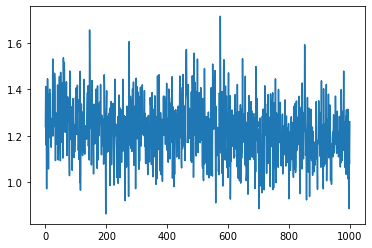

In [115]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# print(all_losses)
plt.figure()
plt.plot(all_losses)
plt.imshow()

In [116]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evalute(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = get_training_sample()
    output = evalute(line_tensor)
#     guess, guess_i = category_from_output(output)
#     category_i = all_categories.index(category)
#     confusion[category_i][guess_i] += 1
    
# for i in range(n_categoreis):
#     confusion[i] = confusion[i] / confusion[i].sum()
    
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(confusion.numpy())
# fig.colorbar(cax)
# ax.set_xticklabels([''] + all_categories, rotation=90)
# ax.set_yticklabels([''] + all_categories)

# # Force label at every tick
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# # sphinx_gallery_thumbnail_number = 2
# plt.show()
    
    

KeyboardInterrupt: 